 ## Defining the problem and assembling a dataset

- Kaggle ASL Alphabet Dataset
  - https://www.kaggle.com/datasets/grassknoted/asl-alphabet
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [585]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from skimage.color import rgb2gray

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [586]:
def get_image(file, size=(32, 32), gray=True) :
    img = Image.open(file_path)
    
    img = img.resize(size, Image.ANTIALIAS)
    
    if gray :
        img = rgb2gray(img)
    
    return np.array(img)

In [592]:
DATASET = 'asl'
IMAGE_SIZE = (32, 32)
SAMPLE_SIZE = 3000

images, labels = [], []
for folder in os.listdir(DATASET) :
    for file in os.listdir(DATASET + '/' + folder)[:SAMPLE_SIZE] :
        file_path = DATASET + '/' + folder + '/' + file
        
        image = get_image(file_path, size=IMAGE_SIZE, gray=True)
        images.append( image )
        
        labels.append(folder)
        
images = np.array(images)
labels = np.array(labels)

In [593]:
Xf = images.reshape((images.shape[0],-1))
yf = labels

In [594]:
TEST_SIZE = 0.15

(Xf_train, Xf_test, 
 yf_train, yf_test) = train_test_split(Xf, yf,  
                                       test_size=TEST_SIZE, stratify=yf,
                                       shuffle=True, random_state=SEED)

In [595]:
scaler = StandardScaler().fit(Xf_train)

X_train, X_test = scaler.transform(Xf_train), scaler.transform(Xf_test)

y_train, y_test = yf_train, yf_test

In [596]:
label_encoder = LabelEncoder()
label_encoder.fit(yf)

y_train = np_utils.to_categorical(label_encoder.transform(yf_train))
y_test = np_utils.to_categorical(label_encoder.transform(yf_test))

In [597]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [598]:
len(yf[yf=='A']), len(yf[yf=='B']), len(yf[yf=='C']), len(yf[yf=='D'])

(3000, 3000, 3000, 0)

In [599]:
baseline = len(yf[yf=='A']) / len(yf)

baseline

0.3333333333333333

In [600]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                                     dropout=np.nan, input_dimension=2, output_dimension=1,
                                     optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                                     name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [601]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [602]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [608]:
slp_model = deep_neural_network(hidden_layers=0,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_250 (Dense)           (None, 3)                 3075      
                                                                 
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________


In [609]:
batch_size = 512
EPOCHS = 500

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [610]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [611]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.83 (baseline=0.33)
Precision (Validation): 0.87
Recall (Validation): 0.79
AUC (Validation): 0.94


In [612]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

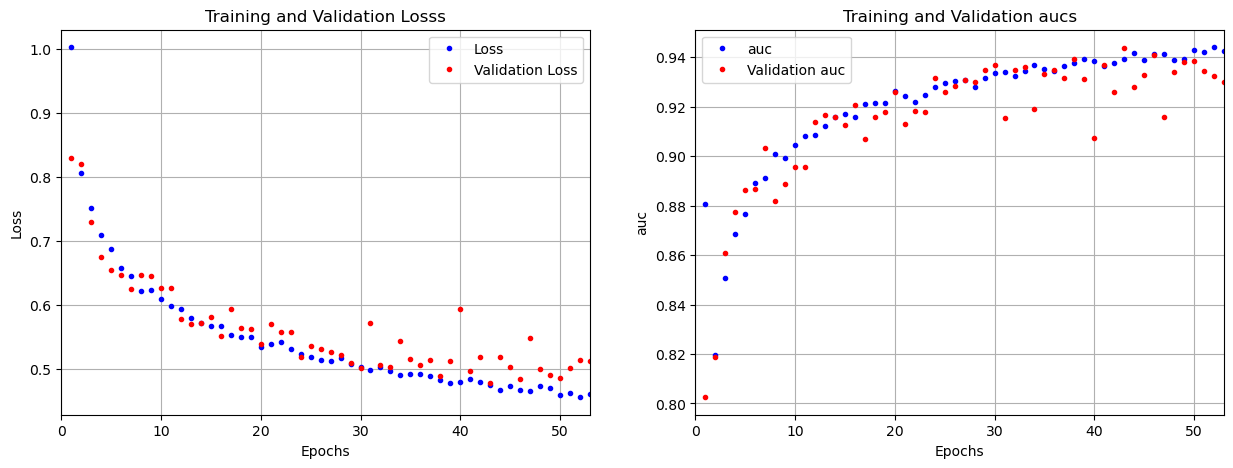

In [613]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [618]:
mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=4,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_253 (Dense)           (None, 4)                 4100      
                                                                 
 dense_254 (Dense)           (None, 3)                 15        
                                                                 
Total params: 4,115
Trainable params: 4,115
Non-trainable params: 0
_________________________________________________________________


In [619]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=750, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

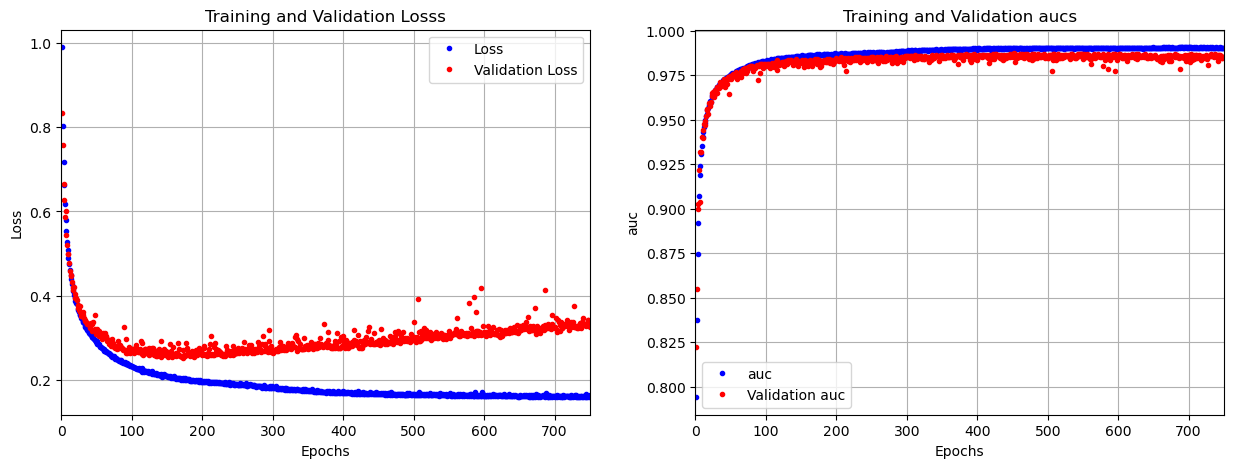

In [620]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [621]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.92 (baseline=0.33)
Precision (Validation): 0.98
Recall (Validation): 0.86
AUC (Validation): 0.99


 ## Regularizing your model and tuning your hyperparameters

In [622]:
# Compute Balanced Accuracy Score for Softmax One-Hot Encoded Output
def compute_balanced_accuracy_score(y, preds) :
    return balanced_accuracy_score(y, preds.flatten())

# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [623]:
# Grid Search CV
def grid_search_cv(X, y,
                   space, cv, 
                   optimizer, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y.argmax(axis=1)) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=optimizer, loss=loss, 
                                        metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate,:]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate,:], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = trained['model'].predict(X[validate,:], verbose=0)
                evaluations.append( value(y[validate,:], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [624]:
addon_metrics = {}

orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [625]:
KFOLDS = 5

In [626]:
params = {
    'hidden_layers': [1, 2],
    'neurons': [4, 8, 16, 32],
    'activation': ['relu'],
    'dropout': [0.25, 0.5],
    'batch_size': [512]
}

stats = grid_search_cv(X_train, y_train,  
                       space=params, cv=KFOLDS, 
                       optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

In [627]:
stats.sort_values(by=['categorical_accuracy'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc
6,1,32,relu,0.25,512,81.8,0.076387,0.981429,0.984056,0.979841,0.997390
14,2,32,relu,0.25,512,63.0,0.085683,0.978413,0.981772,0.975556,0.996364
7,1,32,relu,0.50,512,84.0,0.106257,0.971746,0.976465,0.968254,0.996287
4,1,16,relu,0.25,512,89.4,0.114756,0.970000,0.974069,0.965873,0.995837
12,2,16,relu,0.25,512,102.0,0.119885,0.969841,0.973133,0.966190,0.994871
15,2,32,relu,0.50,512,96.2,0.121519,0.967302,0.971769,0.961905,0.995128
5,1,16,relu,0.50,512,109.8,0.167298,0.950000,0.959467,0.941905,0.992827
2,1,8,relu,0.25,512,97.8,0.204261,0.939206,0.951324,0.923333,0.989420
10,2,8,relu,0.25,512,118.0,0.216565,0.938095,0.944929,0.931111,0.988078
13,2,16,relu,0.50,512,109.8,0.220423,0.931429,0.941443,0.916984,0.988181


In [628]:
opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=32,
                                dropout=0.25, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Narrow_Shallow_Network')

opt_model.summary()

Model: "Narrow_Shallow_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_455 (Dense)           (None, 32)                32800     
                                                                 
 dropout_147 (Dropout)       (None, 32)                0         
                                                                 
 dense_456 (Dense)           (None, 3)                 99        
                                                                 
Total params: 32,899
Trainable params: 32,899
Non-trainable params: 0
_________________________________________________________________


In [629]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

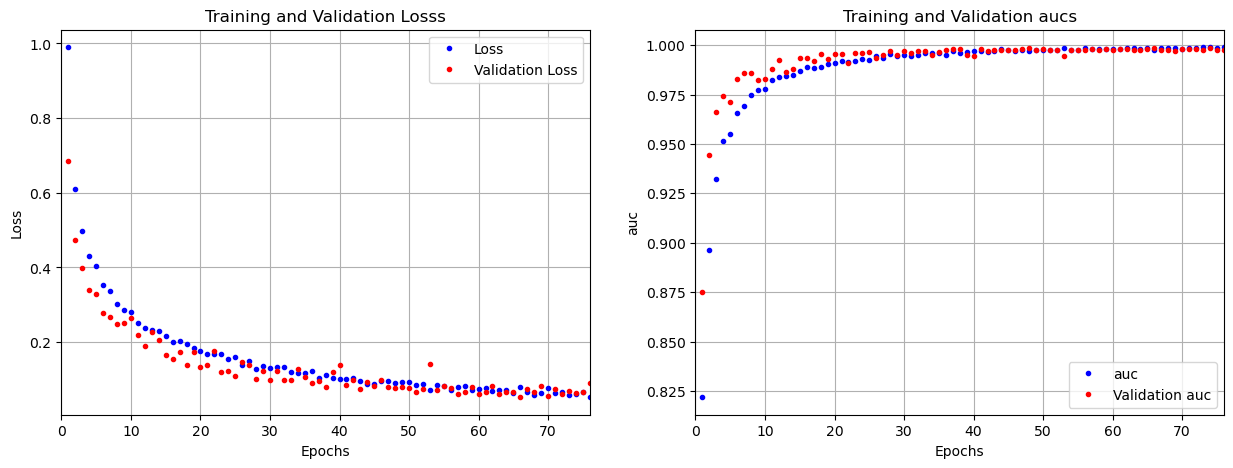

In [630]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [631]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.99 (baseline=0.33)
Precision (Validation): 0.99
Recall (Validation): 0.99
AUC (Validation): 1.00


In [632]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test.argmax(axis=1), 
                                                                      preds.argmax(axis=1)), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                        preds.argmax(axis=1),
                                                        average='macro')))
print('Recall (Test): {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                                  preds.argmax(axis=1),
                                                  average='macro')))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, 
                                                preds,
                                                multi_class='ovo',
                                                average='macro')))

Accuracy (Test): 0.99 (baseline=0.33)
Precision (Test): 0.99
Recall (Test): 0.99
AUC (Test): 1.00


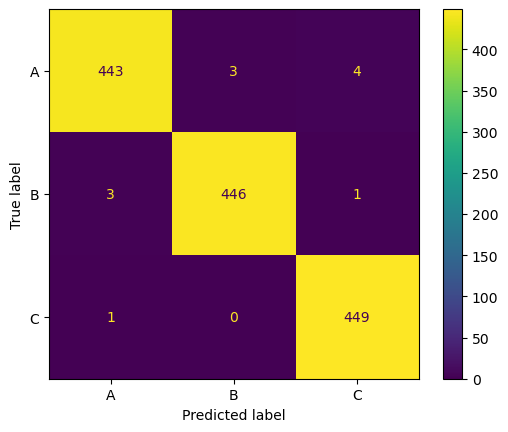

In [633]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=['A', 'B', 'C'])
_ = disp.plot()